# Proyek Klasifikasi Gambar: Garbage Dataset
- **Nama:** Marsha Kamila
- **Email:** cacha.kamila04@gmail.com
- **ID Dicoding:** marsha_kamila

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shakamila","key":"3bf8df0be0b456e1978b1d54d51936c3"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sumn2u/garbage-classification-v2
!unzip garbage-classification-v2.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: garbage-dataset/paper/paper_847.jpg  
  inflating: garbage-dataset/paper/paper_848.jpg  
  inflating: garbage-dataset/paper/paper_849.jpg  
  inflating: garbage-dataset/paper/paper_851.jpg  
  inflating: garbage-dataset/paper/paper_852.jpg  
  inflating: garbage-dataset/paper/paper_853.jpg  
  inflating: garbage-dataset/paper/paper_855.jpg  
  inflating: garbage-dataset/paper/paper_856.jpg  
  inflating: garbage-dataset/paper/paper_857.jpg  
  inflating: garbage-dataset/paper/paper_859.jpg  
  inflating: garbage-dataset/paper/paper_861.jpg  
  inflating: garbage-dataset/paper/paper_863.jpg  
  inflating: garbage-dataset/paper/paper_865.jpg  
  inflating: garbage-dataset/paper/paper_868.jpg  
  inflating: garbage-dataset/paper/paper_870.jpg  
  inflating: garbage-dataset/paper/paper_871.jpg  
  inflating: garbage-dataset/paper/paper_873.jpg  
  inflating: garbage-dataset/paper/paper_874.jpg  
  inflating: garbage-da

### Data Preprocessing

#### Plot Gambar Sampel untuk Dataset Asli

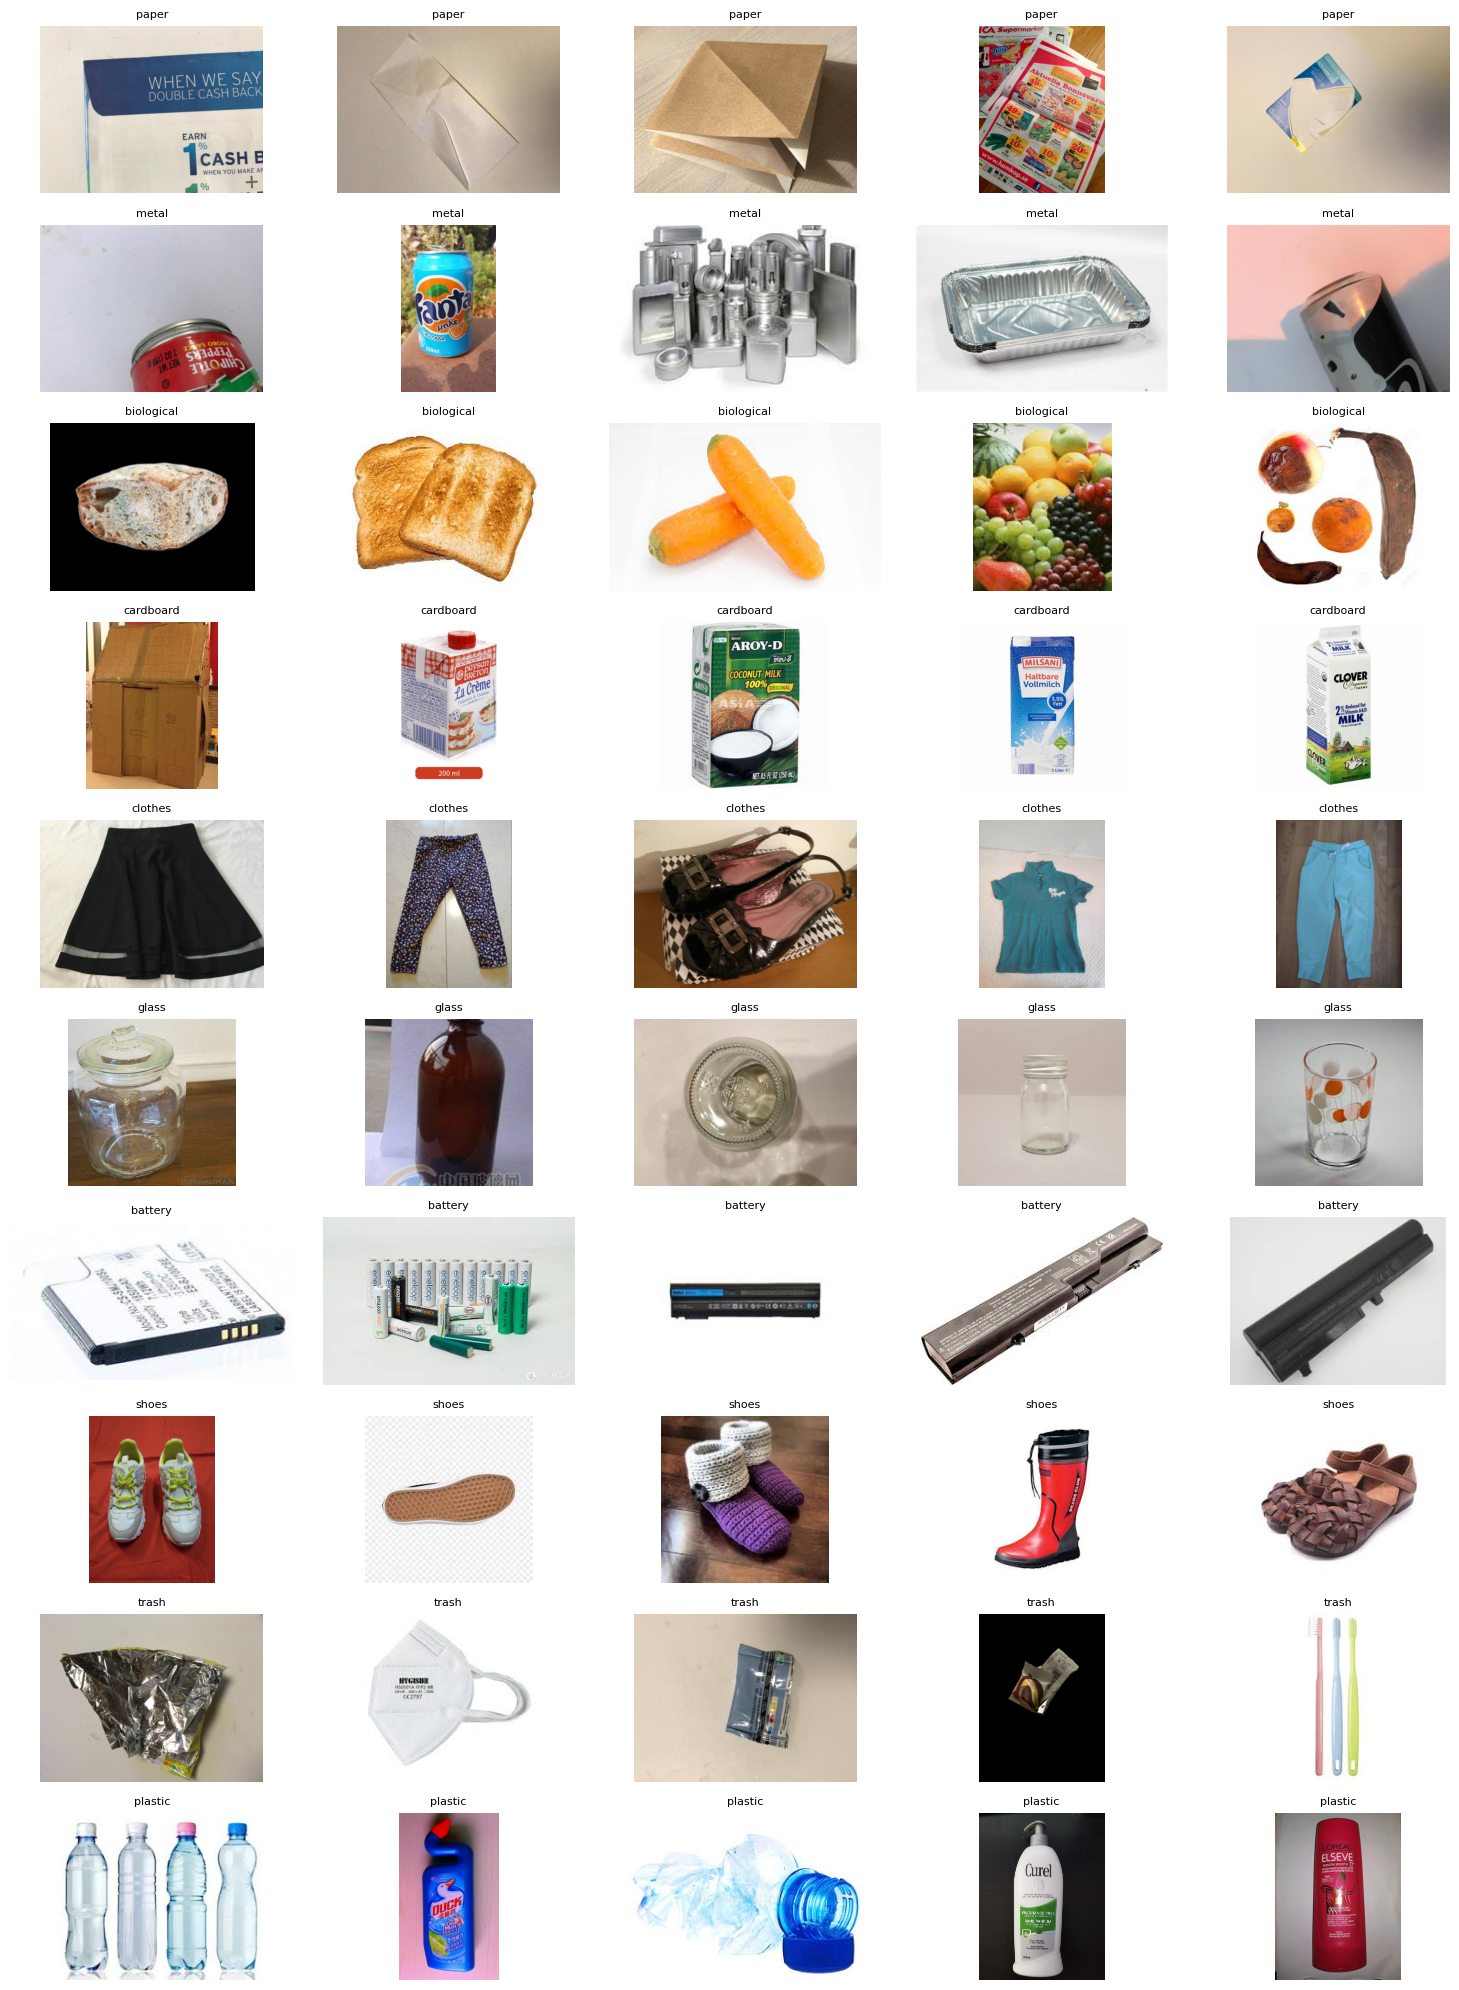

In [5]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
garbage_images = {}

# Tentukan path sumber train
path = "/content/garbage-dataset"

# Iterasi tiap folder kelas
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        garbage_images[class_name] = os.listdir(class_path)

# Menampilkan 5 gambar secara acak untuk setiap kelas
fig, axs = plt.subplots(len(garbage_images.keys()), 5, figsize=(15, 20))

for i, class_name in enumerate(garbage_images.keys()):
    images = np.random.choice(garbage_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=8)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

#### Plot Distribusi Gambar di Dataset asli

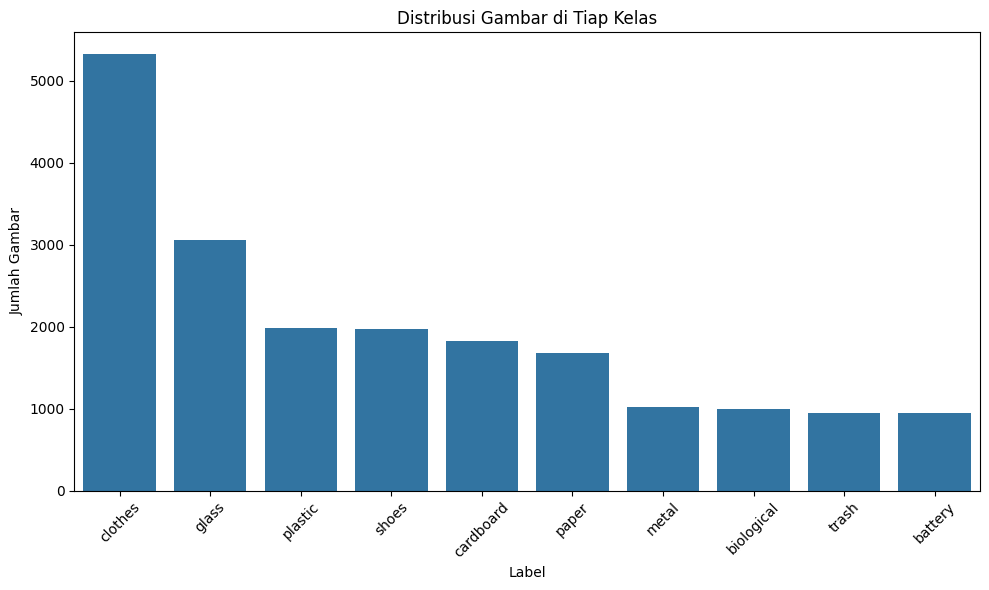

In [6]:
# Create a list that stores data for each filenames, paths, and labels in the data
file_paths = []
file_names = []
labels = []

for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, file))
            file_names.append(file)
            labels.append(class_name)

# Simpan ke DataFrame
df_garbage = pd.DataFrame({
    "path": file_paths,
    "file_name": file_names,
    "label": labels
})

# Plot distribusi
plt.figure(figsize=(10,6))
sns.countplot(data=df_garbage, x='label', order=df_garbage['label'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribusi Gambar di Tiap Kelas")
plt.xlabel("Label")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

#### Mengambil 7 Kelas Saja

In [7]:
# Direktori 7 kelas
glass_dir = "garbage-dataset/glass"
plastic_dir = "garbage-dataset/plastic"
cardboard_dir = "garbage-dataset/cardboard"
paper_dir = "garbage-dataset/paper"
biological_dir = "garbage-dataset/biological"
metal_dir = "garbage-dataset/metal"
trash_dir = "garbage-dataset/trash"

In [8]:
# Direktori dataset gabungan 7 kelas
dir7class = "Garbage/7class"

# Buat direktori baru untuk dataset 7 kelas
import os
os.makedirs(dir7class, exist_ok=True)
os.makedirs(dir7class, exist_ok=True)

In [9]:
# Salin file dan folder dari semua direktori awal
all_dir = [glass_dir, plastic_dir, cardboard_dir, paper_dir, biological_dir, metal_dir, trash_dir]

for dir in all_dir:
  category = os.path.basename(dir)
  dir7kls = os.path.join(dir7class, category)
  shutil.copytree(dir, dir7kls, dirs_exist_ok=True)

#### Plot Distribusi 7 Kelas

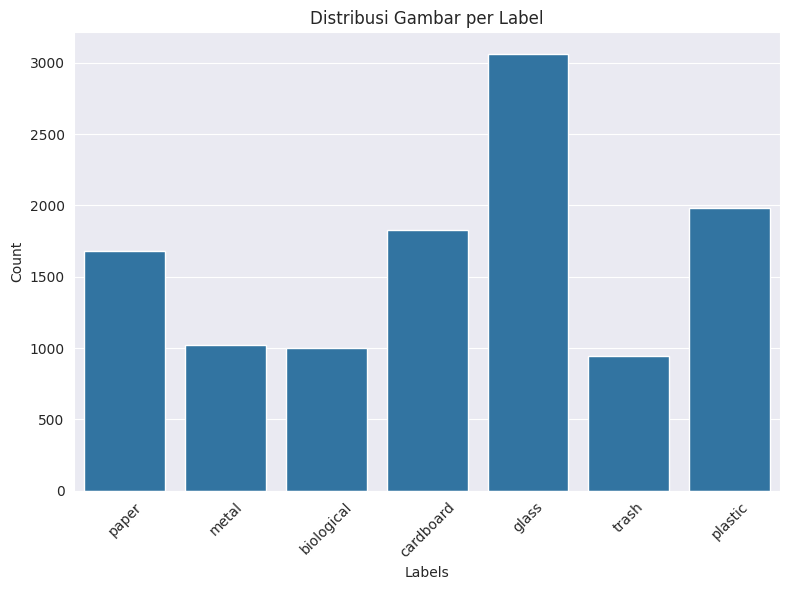

In [10]:
# Path sumber
path = "Garbage/7class/"

# Buat daftar untuk menyimpan data
file_name = []
labels = []
full_path = []

# Looping untuk mendapatkan data gambar
for dir_path, subdirs, files in os.walk(path):
    for name in files:
        full_path.append(os.path.join(dir_path, name))
        labels.append(dir_path.split('/')[-1])
        file_name.append(name)

# Simpan sebagai DataFrame
distribution = pd.DataFrame({'file_name': file_name, 'labels': labels, 'full_path': full_path})

# Plot Distribusi
plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
sns.countplot(x='labels', data=distribution)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribusi Gambar per Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Split Dataset

In [15]:
# Pisahkan X dan y
X = distribution['full_path']
y = distribution['labels']

# Split data menjadi train, validation, dan test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [16]:
# Jumlah data train, val, dan test
print(f'Jumlah data train: {len(X_train)}')
print(f'Jumlah data val: {len(X_val)}')
print(f'Jumlah data test: {len(X_test)}')

Jumlah data train: 7368
Jumlah data val: 1843
Jumlah data test: 2303


In [17]:
# Direktori untuk data train
train_dir = 'Garbage/datatrain'
os.makedirs(train_dir, exist_ok=True)

In [18]:
for x, y in zip(X_train, y_train):
    label_dir = os.path.join(train_dir, y)
    os.makedirs(label_dir, exist_ok=True)

    # Asumsikan x adalah path ke file
    shutil.copy(x, os.path.join(label_dir, os.path.basename(x)))

In [19]:
# Jumlah data setiap label di folder data train
for label in os.listdir(train_dir):
  label_dir = os.path.join(train_dir, label)
  print(f'Jumlah data {label}: {len(os.listdir(label_dir))}')

Jumlah data paper: 1038
Jumlah data metal: 675
Jumlah data biological: 612
Jumlah data cardboard: 1155
Jumlah data glass: 1984
Jumlah data trash: 620
Jumlah data plastic: 1284


#### Data Augmentasi

In [20]:
# === Definisi fungsi augmentasi ===

def anticlockwise_rotation(img):
    img = cv2.resize(img, (224,224))
    sudut = random.uniform(0, 15)
    return rotate(img, sudut, mode='wrap')

def clockwise_rotation(img):
    img = cv2.resize(img, (224,224))
    sudut = random.uniform(0, 15)
    return rotate(img, -sudut, mode='wrap')

def flip_left_right(img):
    img = cv2.resize(img, (224,224))
    return np.fliplr(img)

def add_brightness(img):
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=random.uniform(0.7, 1.5), gain=1)
    return img

def blur_image(img):
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (3,3), 0)

def sheared(img):
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.1)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(random.randint(-10,10), random.randint(-10,10)))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [21]:
# === Kumpulan transformasi ===
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip left right': flip_left_right,
                    'shear image': sheared
                  }

# === Proses augmentasi ===
labels = ['glass', 'plastic', 'cardboard', 'paper', 'biological', 'metal', 'trash']
base_path = 'Garbage/datatrain'
augmented_path = 'Garbage/dataset_augmented'
img_generate = 2000   # tambah 2000 data

for label in labels:
  if label == 'glass':
    continue

  img_path = os.path.join(base_path, label)
  aug_path = os.path.join(augmented_path, label)
  os.makedirs(aug_path, exist_ok=True)

  images = [os.path.join(img_path, im) for im in os.listdir(img_path)]

  i = 1
  while i <= img_generate:
    image = random.choice(images)
    try:
      ori_img = io.imread(image)
      transformed_img = None
      n = 0
      transformation_count = random.randint(1, len(transformations))

      while n <= transformation_count:
        key = random.choice(list(transformations))
        transformed_img = transformations[key](ori_img)
        n += 1

      newimg_path = '%s/augmented_image_%s.jpg' % (aug_path, i)
      transformed_img = img_as_ubyte(transformed_img)
      cv2.imwrite(newimg_path, transformed_img)
      i += 1
    except ValueError as e:
      print('could not read the',image ,':',e,'hence skipping it.')

In [22]:
# Menambahkan hasil augmentasi ke folder dataset train
for label in os.listdir(train_dir):
    aug_label_dir = os.path.join(augmented_path, label)
    target_label_dir = os.path.join(train_dir, label)
    os.makedirs(target_label_dir, exist_ok=True)

    if os.path.exists(aug_label_dir):
        for fname in os.listdir(aug_label_dir):
            src_file = os.path.join(aug_label_dir, fname)
            dst_file = os.path.join(target_label_dir, fname)
            shutil.copy(src_file, dst_file)

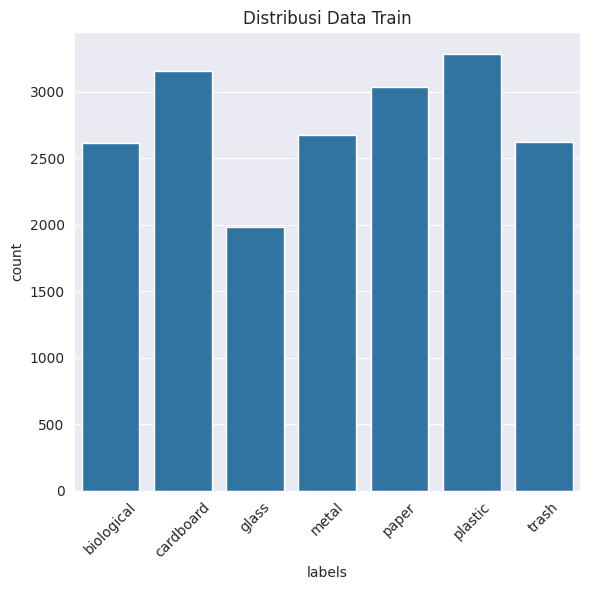

In [23]:
# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Looping nama file gambar, path file, dan label untuk disimpan sebagai dataframe
for path, subdirs, files in os.walk(train_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

distribution_train = pd.DataFrame({
    "path":full_path,
    'file_name':file_name,
    "labels":labels})

# Plot distribusi gambar di setiap kelas
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
sns.countplot(data = distribution_train,
              x = 'labels',
              order = sorted(distribution_train["labels"].unique()))
plt.title("Distribusi Data Train")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [24]:
# Menyatukan ke dalam masing-masing df train, val, dan test
new_Xtrain = []
new_ytrain = []

for label in os.listdir(train_dir):
  label_dir = os.path.join(train_dir, label)
  for fname in os.listdir(label_dir):
    new_Xtrain.append(os.path.join(label_dir, fname))
    new_ytrain.append(label)

df_train = pd.DataFrame({'path': new_Xtrain, 'labels': new_ytrain, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
print(df_all.groupby(['set', 'labels']).size())

set    labels    
test   biological     213
       cardboard      380
       glass          573
       metal          206
       paper          349
       plastic        386
       trash          196
train  biological    2612
       cardboard     3155
       glass         1984
       metal         2675
       paper         3038
       plastic       3284
       trash         2620
val    biological     172
       cardboard      290
       glass          504
       metal          139
       paper          293
       plastic        314
       trash          131
dtype: int64


In [25]:
# Memanggil dataset 7class
datasource_path = "Garbage/7class/"

# Membuat variabel Dataset
dataset_path = "dataset_final/"

for index, row in tq(df_all.iterrows()):
  file_path = row['path']
  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

  # Buat direktori tujuan folder
  if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

  # Tentukan tujuan file
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path,row['set'],row['labels'], destination_file_name)

  # Salin file dari sumber ke tujuan
  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#### Image Data Generator

In [26]:
def rescale_resize(img):
    img_tensor = tf.convert_to_tensor(img)
    image_resize = tf.image.resize_with_pad(img_tensor, 224, 224)
    image = tf.cast(image_resize, tf.float32) / 255.0
    return image.numpy()

datagen = ImageDataGenerator(preprocessing_function=rescale_resize)

train_gen = datagen.flow_from_directory(
    dataset_path + 'train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path + 'val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    dataset_path + 'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 19368 images belonging to 7 classes.
Found 1843 images belonging to 7 classes.
Found 2303 images belonging to 7 classes.


## Modelling

In [27]:
# Load MobileNetV2 tanpa top layer, dengan input shape 224x224x3
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer terlebih dahulu
for layer in mobilenet_base.layers:
    layer.trainable = False

# Fine-tune 10 layer terakhir
for layer in mobilenet_base.layers[-10:]:
    layer.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# Model Sequential
model = Sequential()

# Based Model
model.add(mobilenet_base)

# Layer tambahan
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Global Pooling
model.add(GlobalAveragePooling2D())

# Dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output
model.add(Dense(7, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,012,615 (11.49 MB)

 Trainable params: 1,486,983 (5.67 MB)

 Non-trainable params: 1,525,632 (5.82 MB)

None


In [29]:
# Callback setup
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(train_gen,
                        epochs=10,
                        validation_data=val_gen,
                        callbacks=[early_stop, checkpoint, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7503 - loss: 0.7472

606/606 ━━━━━━━━━━━━━━━━━━━━ 255s 393ms/step - accuracy: 0.7504 - loss: 0.7469 - val_accuracy: 0.7271 - val_loss: 1.4214 - learning_rate: 0.0010
Epoch 2/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8905 - loss: 0.3493

606/606 ━━━━━━━━━━━━━━━━━━━━ 226s 374ms/step - accuracy: 0.8905 - loss: 0.3493 - val_accuracy: 0.7282 - val_loss: 1.3116 - learning_rate: 0.0010
Epoch 3/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9157 - loss: 0.2676

606/606 ━━━━━━━━━━━━━━━━━━━━ 245s 404ms/step - accuracy: 0.9158 - loss: 0.2676 - val_accuracy: 0.8399 - val_loss: 0.6594 - learning_rate: 0.0010
Epoch 4/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9330 - loss: 0.2068

606/606 ━━━━━━━━━━━━━━━━━━━━ 222s 367ms/step - accuracy: 0.9330 - loss: 0.2068 - val_accuracy: 0.8606 - val_loss: 0.5601 - learning_rate: 0.0010
Epoch 5/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 220s 363ms/step - accuracy: 0.9454 - loss: 0.1744 - val_accuracy: 0.8600 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 6/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 221s 365ms/step - accuracy: 0.9563 - loss: 0.1380 - val_accuracy: 0.8535 - val_loss: 0.6283 - learning_rate: 0.0010
Epoch 7/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9650 - loss: 0.1123

606/606 ━━━━━━━━━━━━━━━━━━━━ 219s 361ms/step - accuracy: 0.9650 - loss: 0.1123 - val_accuracy: 0.8660 - val_loss: 0.5478 - learning_rate: 0.0010
Epoch 8/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9699 - loss: 0.0964

606/606 ━━━━━━━━━━━━━━━━━━━━ 216s 356ms/step - accuracy: 0.9699 - loss: 0.0964 - val_accuracy: 0.8709 - val_loss: 0.5443 - learning_rate: 0.0010
Epoch 9/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9742 - loss: 0.0805

606/606 ━━━━━━━━━━━━━━━━━━━━ 214s 353ms/step - accuracy: 0.9742 - loss: 0.0805 - val_accuracy: 0.8888 - val_loss: 0.4207 - learning_rate: 0.0010
Epoch 10/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 209s 345ms/step - accuracy: 0.9765 - loss: 0.0744 - val_accuracy: 0.8459 - val_loss: 0.6786 - learning_rate: 0.0010


## Evaluasi dan Visualisasi

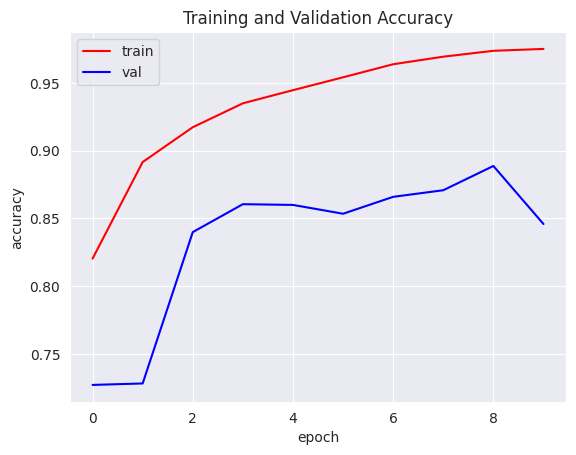

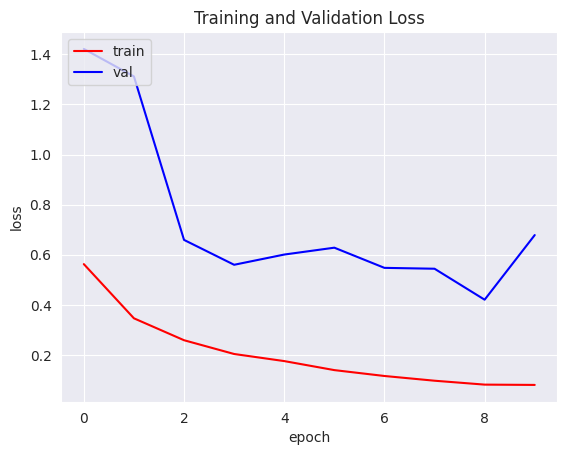

In [30]:
# Ambil data akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [31]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_gen)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 474ms/step - accuracy: 0.9097 - loss: 0.3354
Test loss: 0.41921308636665344
Test accuracy: 0.8818931579589844


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 394ms/step


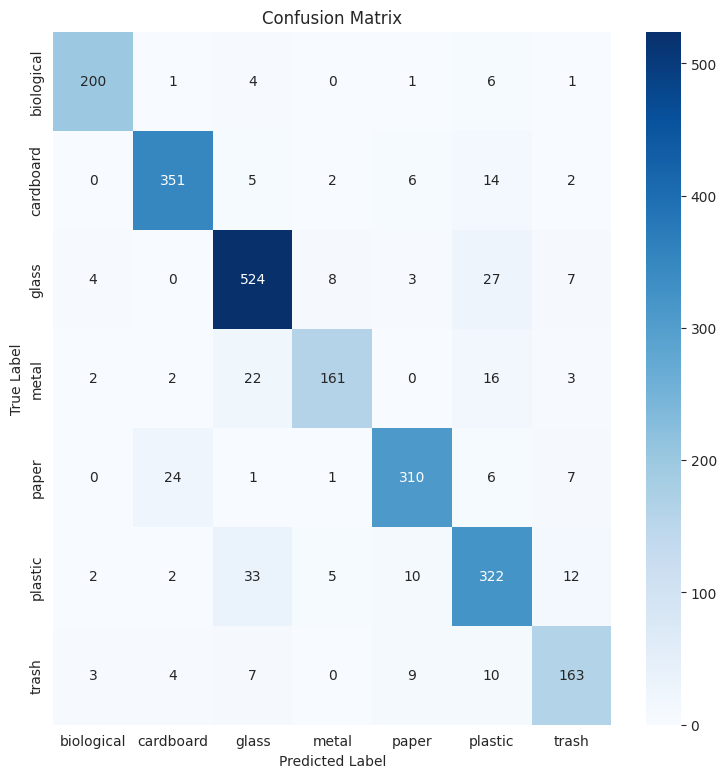

              precision    recall  f1-score   support

  biological       0.95      0.94      0.94       213
   cardboard       0.91      0.92      0.92       380
       glass       0.88      0.91      0.90       573
       metal       0.91      0.78      0.84       206
       paper       0.91      0.89      0.90       349
     plastic       0.80      0.83      0.82       386
       trash       0.84      0.83      0.83       196

    accuracy                           0.88      2303
   macro avg       0.89      0.87      0.88      2303
weighted avg       0.88      0.88      0.88      2303



In [32]:
# Prediksi dan ambil kelas prediksi
predictions = model.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes

# Buat confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(9, 9))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
report = classification_report(true_labels, predicted_labels, target_names=list(test_gen.class_indices.keys()))
print(report)

## Konversi Model

#### Saved Model

In [33]:
model.export('saved_model/')

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140713322746064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322746832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322750480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322750096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322748944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713404322768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322749904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322747408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322750864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322750672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14071332275124

#### TF-Lite

In [34]:
# Konversi model ke TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Label.txt
with open('label.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

Saved artifact at '/tmp/tmpebfw76vh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140713322746064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322746832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322750480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322750096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322748944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713404322768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322749904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322747408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322750864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140713322750672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1407133227

#### TFJS

In [35]:
# Konversi model ke TFJS
!pip install tensorflowjs

!tensorflowjs_converter \
  --input_format=keras \
  best_model.h5 \
  tfjs_model/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-06 16:29:34.307266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746548974.327303   12900 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174